# Sentiment Analysis con KNN
## Clasificador en C++ 💪💪
Vamos a probar a nuestro bichito


Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [1]:
!cd .. && git submodule init
!cd .. && git submodule update
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: build: File exists
-- The C compiler identification is AppleClang 10.0.0.10001145
-- The CXX compiler identification is AppleClang 10.0.0.10001145
-- Check for working C compiler: /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/cc
-- Check for working C compiler: /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/c++
-- Check for working CXX compiler: /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp

In [2]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import sentiment


/Users/vpomsztein/Documents/PrivateRepositories/SentimentAnalysisMetNum/notebooks
Python 3.7.3


In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd

!cd ../data && tar -xvf *.tgz

df = pd.read_csv("../data/imdb_small.csv", index_col=0)

print("Cantidad de documentos: {}".format(df.shape[0]))

x ./._imdb_small.csv
x imdb_small.csv
Cantidad de documentos: 12500


In [4]:
df.describe()

,type,review,label,file
count,12500,12500,12500,12500
unique,2,12469,2,12085
top,test,The fact that this cruddy series could elicit ...,neg,8308_1.txt
freq,6275,2,6322,2


In [5]:
text_train = df[df.type == 'train']["review"]
label_train = df[df.type == 'train']["label"]

text_test = df[df.type == 'test']["review"]
label_test = df[df.type == 'test']["label"]

print("Cantidad de instancias de entrenamiento = {}".format(len(text_train)))
print("Cantidad de instancias de test = {}".format(len(text_test)))



Cantidad de instancias de entrenamiento = 6225
Cantidad de instancias de test = 6275


In [6]:
from __future__ import division
print("Class balance : {} pos {} neg".format(
    (label_train == 'pos').sum() / label_train.shape[0], 
    (label_train == 'neg').sum() / label_train.shape[0]
))


Class balance : 0.49493975903614457 pos 0.5050602409638554 neg


In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.90, min_df=0.01, max_features=5000)

vectorizer.fit(text_train)

X_train, y_train = vectorizer.transform(text_train), (label_train == 'pos').values
X_test, y_test = vectorizer.transform(text_test), (label_test == 'pos').values

In [9]:
import sentiment
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def getMetrics(predictions, actualValues):
    tp = np.sum( np.logical_and(predictions == 1, actualValues == 1) )
    tn = np.sum( np.logical_and(predictions == 0, actualValues == 0) )
    fp = np.sum( np.logical_and(predictions == 1, actualValues == 0) )
    fn = np.sum( np.logical_and(predictions == 0, actualValues == 1) )

    acc = (tp + tn) / (tp+tn+fp+fn)
    if (tp + fp) == 0:
        prec = 0
    else:
        prec = tp / (tp + fp)
    if (tp + fn) == 0:
        rec = 0
    else:
        rec = tp / (tp + fn)
    return acc, prec, rec

In [ ]:
# %%time

# # Esta celda puede ser ejecutada sólo cuando se quiere probar PCA
# pca = sentiment.PCA(100)
# pca.fit(X_train[:500])

In [ ]:
# %%time
# # Idem anterior!

# pca_x_train = pca.transform(X_train[:1000])
# pca_x_test = pca.transform(X_test[:1000])

In [ ]:
%%time
from sklearn.metrics import accuracy_score

# Descomentar la implementación deseada:
# Uncomment this for KNN only (PCA disabled):
clf = sentiment.KNNClassifier(100)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test[:500])
acc = accuracy_score(y_test[:500], y_pred[:500])

# Uncomment this for PCA enabled:
# clf = sentiment.KNNClassifier(500)
# clf.fit(pca_x_train, y_train)

# y_pred = clf.predict(pca_x_test[:500])

acc, prec, rec = getMetrics(y_pred[:500], y_test[:500])

In [ ]:
%%time
## ==================== Experimento 1 ========================
## Análisis de calidad de resultados en base a k y alpha

## Analizo la variación de las métricas en funcion de k

K_vals = np.arange(0,2500,50)
K_vals[0] = 1
mets = np.zeros((len(K_vals), 3))

# pca = sentiment.PCA(50)
# pca.fit(X_train)
# Xtc_train = pca.transform(X_train)
# Xtc_test = pca.transform(X_test)
               
for i,k in enumerate(K_vals):
    clf = sentiment.KNNClassifier(k)
    clf.fit(Xtc_train, y_train)
    preds = clf.predict(Xtc_test)
    acc, prec, rec = getMetrics(preds, y_test)
    mets[i] = [acc, prec, rec]
    print("Finished {}".format(k))
    
plt.plot(K_vals,mets[:,0], 'b.-')
plt.plot(K_vals,mets[:,1], 'r.-')
plt.plot(K_vals,mets[:,2], 'g.-')
plt.title("Metricas en funcion de K")
plt.xlabel("K")
plt.ylabel("%")
plt.axis([1, K_vals[-1], 0.4, 1])
plt.gca().legend(('Acc','Prec','Recall'))

In [11]:
## Analizo la variación de las métricas en funcion de alpha para K fijo

alphas = np.arange(0,500,50)
alphas[0] = 1
K_vals_fixes = np.array([50,550,1100])

dmets = { i : np.zeros((len(alphas), 3)) for i in K_vals_fixes}
dmets

{50: array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), 550: array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), 1100: array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])}

Finished training PCA 1
Finished 50, alpha = 1
Finished 550, alpha = 1
Finished 1100, alpha = 1
Finished training PCA 50
Finished 50, alpha = 50
Finished 550, alpha = 50
Finished 1100, alpha = 50
Finished training PCA 100
Finished 50, alpha = 100
Finished 550, alpha = 100
Finished 1100, alpha = 100
Finished training PCA 150
Finished 50, alpha = 150
Finished 550, alpha = 150
Finished 1100, alpha = 150
Finished training PCA 200
Finished 50, alpha = 200
Finished 550, alpha = 200
Finished 1100, alpha = 200
Finished training PCA 250
Finished 50, alpha = 250
Finished 550, alpha = 250
Finished 1100, alpha = 250
Finished training PCA 300
Finished 50, alpha = 300
Finished 550, alpha = 300
Finished 1100, alpha = 300
Finished training PCA 350
Finished 50, alpha = 350
Finished 550, alpha = 350
Finished 1100, alpha = 350
Finished training PCA 400
Finished 50, alpha = 400
Finished 550, alpha = 400
Finished 1100, alpha = 400
Finished training PCA 450
Finished 50, alpha = 450
Finished 550, alpha = 450

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


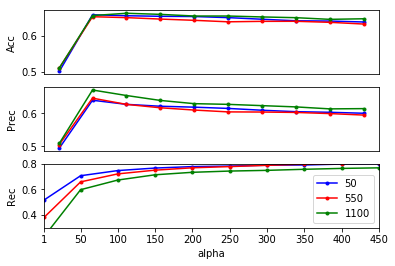

In [12]:
print("Beginning alpha metric calculations")

for i,a in enumerate(alphas):
    
    pca = sentiment.PCA(a)
    pca.fit(X_train)
    Xtc_train = pca.transform(X_train)
    Xtc_test = pca.transform(X_test)
    print("Finished training PCA {}".format(a))

    for j, k in enumerate(K_vals_fixes):
        clf = sentiment.KNNClassifier(k)
        clf.fit(Xtc_train, y_train)
        preds = clf.predict(Xtc_test)
        acc, prec, rec = getMetrics(preds, y_test)
        mets = dmets[k]
        mets[i] = [acc, prec, rec]
        print("Finished {}, alpha = {}".format(k, a))


## Metricas para PCA:

line_styles = ['b.-', 'r.-', 'g.-', 'k.-', 'y.-', 'm.-']
for j,k in enumerate(K_vals_fixes):
    mets = dmets[k]

    plt.subplot(3, 1, 1)
    plt.plot(alphas,mets[:,0], line_styles[j])
    plt.ylabel("Acc")
    plt.xticks([])

    plt.subplot(3, 1, 2)
    plt.plot(alphas,mets[:,1], line_styles[j])
    plt.ylabel("Prec")
    plt.xticks([])
    
    plt.subplot(3, 1, 3)
    plt.plot(alphas,mets[:,2], line_styles[j])
    plt.ylabel("Rec")
    plt.xticks([])

    
plt.xlabel("alpha")
plt.xticks(alphas)
plt.axis([1, alphas[-1], 0.3, 0.8])
plt.gca().legend([str(i) for i in K_vals_fixes])